### Clone

In [1]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 4817 (delta 18), reused 15 (delta 5), pack-reused 4779
Receiving objects: 100% (4817/4817), 7.81 MiB | 12.36 MiB/s, done.
Resolving deltas: 100% (3279/3279), done.


In [2]:
#환경설정

%cd yolov5
%pip install -qr requirements.txt

/content/yolov5
     |████████████████████████████████| 645kB 8.2MB/s 


### mount

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
from IPython.display import Image, clear_output  # to display images

#GPU, CPU 사용 유무
clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


### yolo test

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='data/images/', update=False, view_img=False, weights=['yolov5s.pt'])
YOLOv5 v4.0-77-g3e560e2 torch 1.7.0+cu101 CPU

100% 14.1M/14.1M [00:00<00:00, 43.3MB/s]

Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients, 17.0 GFLOPS
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.187s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 1 tie, Done. (0.107s)
Results saved to runs/detect/exp
Done. (0.459s)


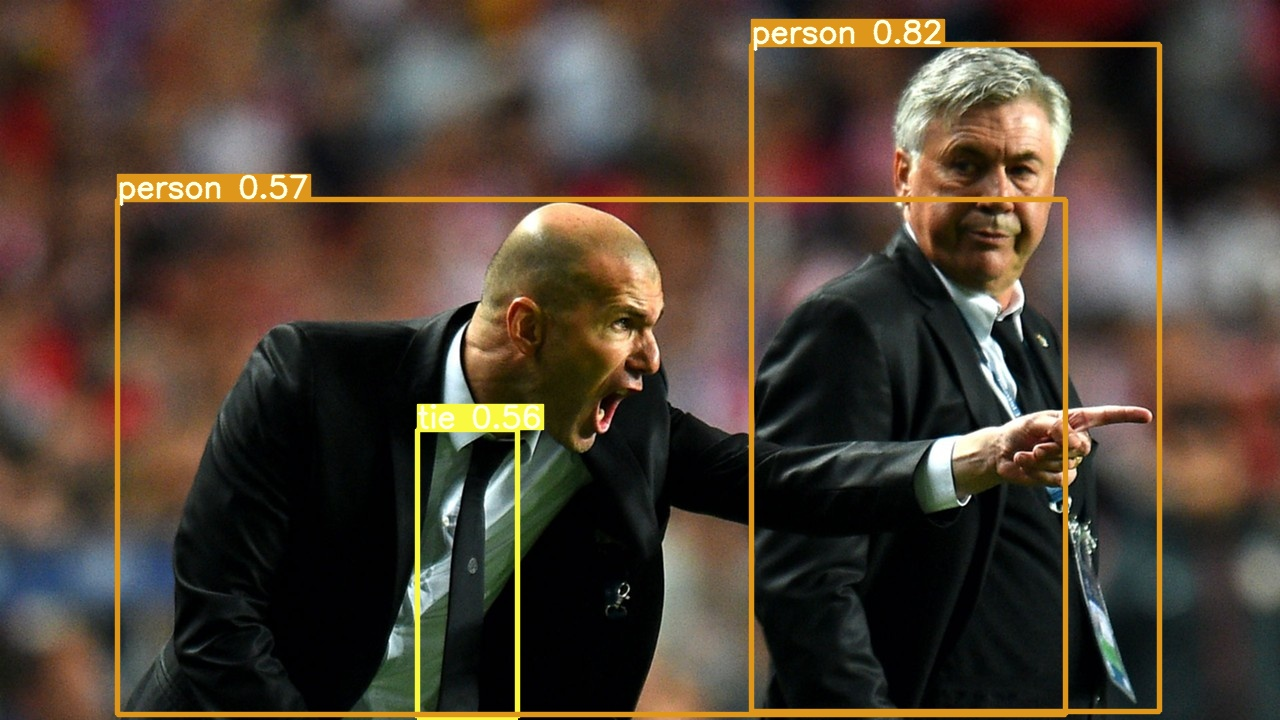

In [ ]:
#yolov5 임시 테스트
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

In [ ]:
!pip3 install -U -qq seaborn 

In [ ]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [ ]:
fold = 5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# height width가 담긴 train2.csv height width 역시 kaggle data 에서 찾았음.
train_df = pd.read_csv(f'/content/drive/MyDrive/kaggle/train2.csv')
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332
1,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R15,NaN,NaN,NaN,NaN,2580,2332
2,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R16,NaN,NaN,NaN,NaN,2580,2332
3,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,3159,2954
4,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R13,NaN,NaN,NaN,NaN,3159,2954


In [ ]:
#파일 패스. 임의로 경로 설정하시면 됩니다.
train_df['image_path'] = f'/content/drive/MyDrive/kaggle/train/'+train_df.image_id+'.png'
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332,/content/drive/MyDrive/kaggle/train/50a418190b...
1,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R15,NaN,NaN,NaN,NaN,2580,2332,/content/drive/MyDrive/kaggle/train/50a418190b...
2,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R16,NaN,NaN,NaN,NaN,2580,2332,/content/drive/MyDrive/kaggle/train/50a418190b...
3,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,3159,2954,/content/drive/MyDrive/kaggle/train/21a10246a5...
4,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R13,NaN,NaN,NaN,NaN,3159,2954,/content/drive/MyDrive/kaggle/train/21a10246a5...


In [ ]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True)

In [ ]:
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width,image_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...
1,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,1789.0,1729.0,1875.0,1992.0,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,1789.0,1729.0,1875.0,1992.0,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...
3,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,692.0,1375.0,1657.0,1799.0,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...
4,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,689.0,1313.0,1666.0,1763.0,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...


In [ ]:
#yolo는 비율로 하기 때문에 비율로 고쳐주는 함수
train_df['x_min'] = train_df.apply(lambda row: (row.x_min)/row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min)/row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max)/row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max)/row.height, axis =1)

train_df['x_mid'] = train_df.apply(lambda row: (row.x_max+row.x_min)/2, axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_max+row.y_min)/2, axis =1)

train_df['w'] = train_df.apply(lambda row: (row.x_max-row.x_min), axis =1)
train_df['h'] = train_df.apply(lambda row: (row.y_max-row.y_min), axis =1)

train_df['area'] = train_df['w']*train_df['h']
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width,image_path,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.563462,0.686216,0.462500,0.195205,0.090283
1,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,R9,0.860096,0.740154,0.901442,0.852740,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.880769,0.796447,0.041346,0.112586,0.004655
2,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,R9,0.860096,0.740154,0.901442,0.852740,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.880769,0.796447,0.041346,0.112586,0.004655
3,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R9,0.332692,0.588613,0.796635,0.770120,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.564663,0.679366,0.463942,0.181507,0.084209
4,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R8,0.331250,0.562072,0.800962,0.754709,2336,2080,/content/drive/MyDrive/kaggle/train/9a5094b256...,0.566106,0.658390,0.469712,0.192637,0.090484


In [ ]:
tables = []
for i in range(14):
  tables.append(train_df[train_df['class_id']==i])

In [ ]:
for i in range(14):
  print(i,len(tables[i]))

0 7162
1 279
2 960
3 5427
4 556
5 1000
6 1247
7 2483
8 2580
9 2203
10 2476
11 4842
12 226
13 4655


In [ ]:
samples = []
for i in range(14):
  samples.append(tables[i].sample(n=226))

In [ ]:
for i in range(14):
  print(i,len(samples[i]))

0 226
1 226
2 226
3 226
4 226
5 226
6 226
7 226
8 226
9 226
10 226
11 226
12 226
13 226


In [ ]:
Sample = pd.concat(samples)

In [ ]:
len(Sample)

3164

In [ ]:
train_df = Sample.copy()
train_df = train_df.sort_index()
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width,image_path,x_mid,y_mid,w,h,area
8,051132a778e61a86eb147c7c6f564dfe,Cardiomegaly,3,R8,0.411458,0.439931,0.895399,0.580556,2880,2304,/content/drive/MyDrive/kaggle/train/051132a778...,0.653429,0.510243,0.483941,0.140625,0.068054
25,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R15,0.070460,0.021918,0.926477,0.866145,2555,2285,/content/drive/MyDrive/kaggle/train/0c7a38f293...,0.498468,0.444031,0.856018,0.844227,0.722673
30,47ed17dcb2cbeec15182ed335a8b5a9e,Other lesion,9,R9,0.667835,0.270206,0.799844,0.413659,3353,2568,/content/drive/MyDrive/kaggle/train/47ed17dcb2...,0.733840,0.341933,0.132009,0.143454,0.018937
44,d3637a1935a905b3c326af31389cb846,Nodule/Mass,8,R9,0.242188,0.644444,0.265625,0.660417,2880,2304,/content/drive/MyDrive/kaggle/train/d3637a1935...,0.253906,0.652431,0.023438,0.015972,0.000374
53,afb6230703512afc370f236e8fe98806,Lung Opacity,7,R9,0.731102,0.523112,0.837008,0.662760,3072,2540,/content/drive/MyDrive/kaggle/train/afb6230703...,0.784055,0.592936,0.105906,0.139648,0.014790


In [ ]:
new_index = [i for i in range(len(train_df))]
len(new_index)

3164

In [ ]:
train_df.index = new_index
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width,image_path,x_mid,y_mid,w,h,area
0,051132a778e61a86eb147c7c6f564dfe,Cardiomegaly,3,R8,0.411458,0.439931,0.895399,0.580556,2880,2304,/content/drive/MyDrive/kaggle/train/051132a778...,0.653429,0.510243,0.483941,0.140625,0.068054
1,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R15,0.070460,0.021918,0.926477,0.866145,2555,2285,/content/drive/MyDrive/kaggle/train/0c7a38f293...,0.498468,0.444031,0.856018,0.844227,0.722673
2,47ed17dcb2cbeec15182ed335a8b5a9e,Other lesion,9,R9,0.667835,0.270206,0.799844,0.413659,3353,2568,/content/drive/MyDrive/kaggle/train/47ed17dcb2...,0.733840,0.341933,0.132009,0.143454,0.018937
3,d3637a1935a905b3c326af31389cb846,Nodule/Mass,8,R9,0.242188,0.644444,0.265625,0.660417,2880,2304,/content/drive/MyDrive/kaggle/train/d3637a1935...,0.253906,0.652431,0.023438,0.015972,0.000374
4,afb6230703512afc370f236e8fe98806,Lung Opacity,7,R9,0.731102,0.523112,0.837008,0.662760,3072,2540,/content/drive/MyDrive/kaggle/train/afb6230703...,0.784055,0.592936,0.105906,0.139648,0.014790


In [ ]:
gkf  = GroupKFold(n_splits = 5)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, groups = train_df.image_id.tolist())):
    train_df.loc[val_idx, 'fold'] = fold
train_df.head()

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,height,width,image_path,x_mid,y_mid,w,h,area,fold
0,051132a778e61a86eb147c7c6f564dfe,Cardiomegaly,3,R8,0.411458,0.439931,0.895399,0.580556,2880,2304,/content/drive/MyDrive/kaggle/train/051132a778...,0.653429,0.510243,0.483941,0.140625,0.068054,1
1,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R15,0.070460,0.021918,0.926477,0.866145,2555,2285,/content/drive/MyDrive/kaggle/train/0c7a38f293...,0.498468,0.444031,0.856018,0.844227,0.722673,0
2,47ed17dcb2cbeec15182ed335a8b5a9e,Other lesion,9,R9,0.667835,0.270206,0.799844,0.413659,3353,2568,/content/drive/MyDrive/kaggle/train/47ed17dcb2...,0.733840,0.341933,0.132009,0.143454,0.018937,2
3,d3637a1935a905b3c326af31389cb846,Nodule/Mass,8,R9,0.242188,0.644444,0.265625,0.660417,2880,2304,/content/drive/MyDrive/kaggle/train/d3637a1935...,0.253906,0.652431,0.023438,0.015972,0.000374,1
4,afb6230703512afc370f236e8fe98806,Lung Opacity,7,R9,0.731102,0.523112,0.837008,0.662760,3072,2540,/content/drive/MyDrive/kaggle/train/afb6230703...,0.784055,0.592936,0.105906,0.139648,0.014790,2


In [ ]:
train_files = []
val_files   = []
val_files += list(train_df[train_df.fold==fold].image_path.unique())
train_files += list(train_df[train_df.fold!=fold].image_path.unique())
len(train_files), len(val_files)

(1526, 381)

In [ ]:
# 먼저 각 txt 생성
label_dir = '/content/drive/MyDrive/kaggle/train_labels/'
for i in train_df['image_id'].unique():
  f = open(f'{label_dir}{i}.txt','w')
  f.close()

In [ ]:
#txt 마다 증상 적기, 만약 많은 증상이 있다면 다음줄로 넘어가서 적기 텍스트를 추가해야하기 때문에 'a'사용
label_dir = '/content/drive/MyDrive/kaggle/train_labels/'
for i in range(len(train_df)):
  train_data = train_df.iloc[i]
  filename = train_data['image_id']
  f = open(f'{label_dir}{filename}.txt','a')
  f.write(f"{train_data['class_id']} {train_data['x_mid']} {train_data['y_mid']} {train_data['w']} {train_data['h']}\n")
  f.close()


In [ ]:
# 이것을 labels , images, train, val 로 자동으로 나눠주기 기본으로 했을 때 20분정도 걸린걸로
os.makedirs('/content/drive/MyDrive/kaggle/labels/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/kaggle/labels/val', exist_ok = True)
os.makedirs('/content/drive/MyDrive/kaggle/images/train', exist_ok = True)
os.makedirs('/content/drive/MyDrive/kaggle/images/val', exist_ok = True)
label_dir = '/content/drive/MyDrive/kaggle/train_labels'
for file in tqdm(train_files):
    shutil.copy(file, '/content/drive/MyDrive/kaggle/images/train')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/kaggle/labels/train')
    
for file in tqdm(val_files):
    shutil.copy(file, '/content/drive/MyDrive/kaggle/images/val')
    filename = file.split('/')[-1].split('.')[0]
    shutil.copy(os.path.join(label_dir, filename+'.txt'), '/content/drive/MyDrive/kaggle/labels/val')

In [ ]:
#yolo classes
class_ids, class_names = list(zip(*set(zip(train_df.class_id, train_df.class_name))))
classes = list(np.array(class_names)[np.argsort(class_ids)])
classes = list(map(lambda x: str(x), classes))
classes

['Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

In [ ]:
from os import listdir
from os.path import isfile, join
import yaml
# yolo train.txt val.txt 적기
cwd = '/content/drive/MyDrive/kaggle/working/'

with open(join( cwd , 'train.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/kaggle/images/train/*'):
        f.write(path+'\n')
            
with open(join( cwd , 'val.txt'), 'w') as f:
    for path in glob('/content/drive/MyDrive/kaggle/images/val/*'):
        f.write(path+'\n')

data = dict(
    train =  join( cwd , 'train.txt') ,
    val   =  join( cwd , 'val.txt' ),
    nc    = 14,
    names = classes
    )

with open(join( cwd , 'vinbigdata.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(join( cwd , 'vinbigdata.yaml'), 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- Aortic enlargement
- Atelectasis
- Calcification
- Cardiomegaly
- Consolidation
- ILD
- Infiltration
- Lung Opacity
- Nodule/Mass
- Other lesion
- Pleural effusion
- Pleural thickening
- Pneumothorax
- Pulmonary fibrosis
nc: 14
train: /content/drive/MyDrive/kaggle/working/train.txt
val: /content/drive/MyDrive/kaggle/working/val.txt



In [ ]:
#마지막으로 CPU, GPU 확인 train 시작
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0+cu101 CPU


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='data/images/', update=False, view_img=False, weights=['yolov5l.pt'])
YOLOv5 v4.0-77-g3e560e2 torch 1.7.0+cu101 CPU

Fusing layers... 
Model Summary: 392 layers, 47025981 parameters, 0 gradients, 115.4 GFLOPS
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, 1 handbag, 1 potted plant, Done. (0.274s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 3 persons, 2 ties, Done. (0.230s)
Results saved to runs/detect/exp4
Done. (0.588s)


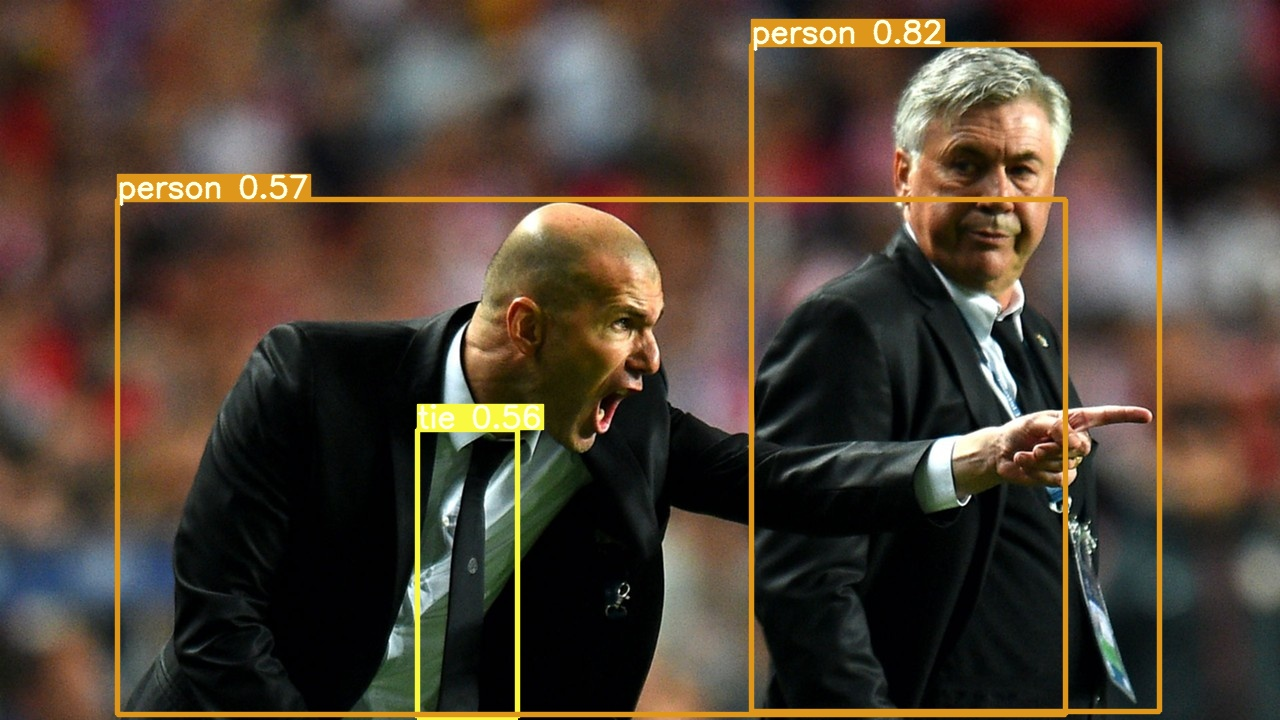

In [ ]:
#yolov5 임시 테스트
!python detect.py --weights yolov5l.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

### train

In [11]:
!rm -r /content/yolov5/runs/train

In [12]:
!WANDB_MODE="dryrun" python /content/yolov5/train.py --img 640 --batch 16 --epochs 200 --data /content/drive/MyDrive/kaggle/working/vinbigdata.yaml --weights /content/yolov5/yolov5s.pt --cache

github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 v4.0-79-g7b833e3 torch 1.7.0+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='', data='/content/drive/MyDrive/kaggle/working/vinbigdata.yaml', device='', epochs=200, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[640, 640], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', single_cls=False, sync_bn=False, total_batch_size=16, weights='/content/yolov5/yolov5s.pt', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboard with "tensorboard --logdir runs/train", view at http://localhost:6006/
2021-02-16 01:16:46.626468: I tensorflow/stre

In [14]:
!python detect.py --weights 'runs/train/exp/weights/best.pt' --img 640 --conf 0.15 --iou 0.4 --source /content/drive/MyDrive/kaggle/test/ --save-txt --save-conf --exist-ok


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.15, device='', exist_ok=True, img_size=640, iou_thres=0.4, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/content/drive/MyDrive/kaggle/test/', update=False, view_img=False, weights=['runs/train/exp/weights/best.pt'])
YOLOv5 v4.0-79-g7b833e3 torch 1.7.0+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 224 layers, 7088971 parameters, 0 gradients, 16.4 GFLOPS
image 1/3000 /content/drive/MyDrive/kaggle/test/002a34c58c5b758217ed1f584ccbcfe9.png: 640x640 1 Cardiomegaly, Done. (0.012s)
image 2/3000 /content/drive/MyDrive/kaggle/test/004f33259ee4aef671c2b95d54e4be68.png: 640x640 1 Aortic enlargement, 1 Cardiomegaly, Done. (0.011s)
image 3/3000 /content/drive/MyDrive/kaggle/test/008bdde2af2462e86fd373a445d0f4cd.png: 640x640 1 Aortic enlargement, 1 Cardiomegaly, Done. (0.011s)
image 4/3000 /content/drive/MyDrive/kaggle/test/009bc039326338823ca3aa84381f17f1.png: 64

In [17]:
!cp /content/yolov5/runs/train/exp/weights/best.pt /content/drive/MyDrive/kaggle/working/yolo2

In [27]:
import pandas as pd
from tqdm.notebook import tqdm

In [21]:
width_height = pd.read_csv('/content/drive/MyDrive/kaggle/working/test_width_height.csv')

In [22]:
width_height.head()

,id,height,width
0,83caa8a85e03606cf57e49147d7ac569,2880,2304
1,7550347fa2bb96c2354a3716dfa3a69c,3095,2538
2,74b23792db329cff5843e36efb8aa65a,3120,2788
3,94568a546be103177cb582d3e91cd2d8,2430,1994
4,6da36354fc904b63bc03eb3884e0c35c,2376,2056


In [23]:
print(len(width_height))

3000


In [24]:
width_height['PredictionString'] = ""
width_height.head()

,id,height,width,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,2880,2304,
1,7550347fa2bb96c2354a3716dfa3a69c,3095,2538,
2,74b23792db329cff5843e36efb8aa65a,3120,2788,
3,94568a546be103177cb582d3e91cd2d8,2430,1994,
4,6da36354fc904b63bc03eb3884e0c35c,2376,2056,


In [25]:
id = width_height.iloc[3][0]
txt = f'runs/detect/exp/labels/{id}.txt'
with open(txt,'r') as f :
  lines = f.readlines()
  for line in lines:
    print(line)

3 0.546387 0.728516 0.418945 0.125 0.43042



In [28]:
for i in tqdm(range(len(width_height))):
  try:
    id = width_height.iloc[i][0]
    txt = f'runs/detect/exp/labels/{id}.txt'
    with open(txt,'r') as f :
      lines = f.readlines()
      for line in lines:
        Class,Prop,x_mid,y_mid,width,height = line.split(' ')
        x_min = int(float(float(x_mid) - float(width)/2)*width_height.iloc[i][2])
        x_max = int(float(float(x_mid) + float(width)/2)*width_height.iloc[i][2])
        y_min = int(float(float(y_mid) - float(height)/2)*width_height.iloc[i][1])
        y_max = int(float(float(y_mid) + float(height)/2)*width_height.iloc[i][1])
        STring = width_height.iloc[i,3]
        STring2 = f"{STring}{Class} {Prop} {x_min} {y_min} {x_max} {y_max} "
        width_height.iloc[i,3] = STring2
  except : 
    width_height.iloc[i,3] = '14 1 0 0 1 1'

In [29]:
width_height2 = width_height.copy()
width_height2.head()

,id,height,width,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,2880,2304,3 0.558594 931 854 1257 1699 4 0.195312 389 -1...
1,7550347fa2bb96c2354a3716dfa3a69c,3095,2538,5 0.737305 557 648 1752 1128 5 0.246094 567 52...
2,74b23792db329cff5843e36efb8aa65a,3120,2788,14 1 0 0 1 1
3,94568a546be103177cb582d3e91cd2d8,2430,1994,3 0.546387 1328 495 1577 1540
4,6da36354fc904b63bc03eb3884e0c35c,2376,2056,0 0.579102 471 21 658 507 9 0.503906 1074 -191...


In [30]:
width_height2 = width_height2.drop(['height','width'],axis=1)
width_height2.head()

,id,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,3 0.558594 931 854 1257 1699 4 0.195312 389 -1...
1,7550347fa2bb96c2354a3716dfa3a69c,5 0.737305 557 648 1752 1128 5 0.246094 567 52...
2,74b23792db329cff5843e36efb8aa65a,14 1 0 0 1 1
3,94568a546be103177cb582d3e91cd2d8,3 0.546387 1328 495 1577 1540
4,6da36354fc904b63bc03eb3884e0c35c,0 0.579102 471 21 658 507 9 0.503906 1074 -191...


In [31]:
width_height2.columns = ['image_id','PredictionString']
width_height2.head()

,image_id,PredictionString
0,83caa8a85e03606cf57e49147d7ac569,3 0.558594 931 854 1257 1699 4 0.195312 389 -1...
1,7550347fa2bb96c2354a3716dfa3a69c,5 0.737305 557 648 1752 1128 5 0.246094 567 52...
2,74b23792db329cff5843e36efb8aa65a,14 1 0 0 1 1
3,94568a546be103177cb582d3e91cd2d8,3 0.546387 1328 495 1577 1540
4,6da36354fc904b63bc03eb3884e0c35c,0 0.579102 471 21 658 507 9 0.503906 1074 -191...


In [32]:
width_height2.to_csv('/content/drive/MyDrive/kaggle/result_csv/submission2.csv',index=None)


In [33]:
!cp -r runs/detect/exp/labels /content/drive/MyDrive/kaggle/test_result/yolo2